In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Movie Recommender

## 1. Load data

In [8]:
ratings = pd.read_csv("data/movie_recommender/ratings.csv")
movies = pd.read_csv("data/movie_recommender/movies.csv")

In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
ratings = ratings.drop(columns="timestamp")
movies = movies.drop(columns="genres")

In [12]:
movies.shape

(9742, 2)

In [13]:
ratings.shape

(100836, 3)

In [16]:
ratings["userId"].nunique()

610

## 2. Create feature set

based on user ratings for movies

Dataset design:

| movieId | user1 | user2 | ... | userN |
|---------|-------|-------|-----|-------|
| 1 | NA | 1 | ... | 5 |
| 2 | 3 | NA | ... | 2 |


### First, however, we need to filter movies with almost no ratings. Those may not yield meaningful recommendations.

1. Count ratings for each movieId
2. join ratings on count from previous step
3. fitler

In [26]:
no_of_ratings = (ratings
                 .groupby("movieId", as_index=False)
                 .agg({"userId": "count"})
                 .rename(columns={"userId": "no_of_ratings"}))

In [28]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [30]:
df = ratings.merge(movies, how="left", on="movieId")

In [33]:
df = df.merge(no_of_ratings, how="left", on="movieId")

In [34]:
df.head()

,userId,movieId,rating,title,no_of_ratings
0,1,1,4.0,Toy Story (1995),215
1,1,3,4.0,Grumpier Old Men (1995),52
2,1,6,4.0,Heat (1995),102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.0,"Usual Suspects, The (1995)",204


### Plot distribution of no_of_ratings

In [37]:
no_of_ratings

,movieId,no_of_ratings
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49
...,...,...
9719,193581,1
9720,193583,1
9721,193585,1
9722,193587,1


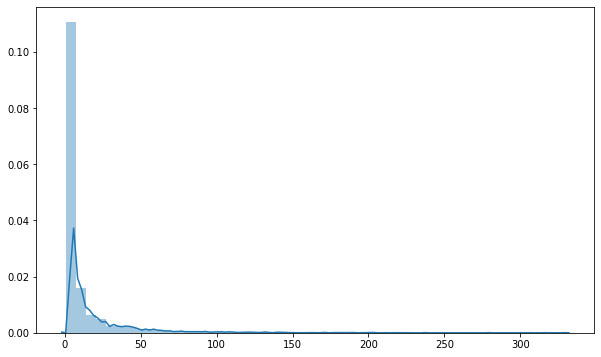

In [39]:
plt.figure(figsize=(10,6))
sns.distplot(no_of_ratings.set_index("movieId"));

In [40]:
no_of_ratings.describe()

,movieId,no_of_ratings
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


Set lower threshold for no_of_ratings to 5

In [41]:
min_threshold = 5
final_movies = df[df["no_of_ratings"] >= 5].copy()

### Create feature set

| movieId | user1 | user2 | ... | userN |
|---------|-------|-------|-----|-------|
| 1 | NA | 1 | ... | 5 |
| 2 | 3 | NA | ... | 2 |

In [45]:
movie_features = final_movies.pivot_table(index="movieId",
                                          columns="userId",
                                          values="rating").fillna(0)

In [47]:
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Modelling

In [48]:
from scipy.sparse import csr_matrix

In [50]:
mat_movie_features = csr_matrix(movie_features)

## 3.1. Train KNN (K-Nearest-Neighbors)

In [51]:
from sklearn.neighbors import NearestNeighbors

In [78]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [71]:
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
movie_features.loc[1].values.reshape(1, -1)

array([[4. , 0. , 0. , 0. , 4. , 0. , 4.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 2.5, 0. , 4.5, 3.5, 4. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. ,
        3. , 0. , 0. , 0. , 5. , 3. , 3. , 0. , 0. , 0. , 0. , 0. , 0. ,
        5. , 0. , 0. , 5. , 3. , 4. , 5. , 0. , 0. , 0. , 3. , 0. , 0. ,
        0. , 3. , 0. , 0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. , 0. ,
        4. , 0. , 2.5, 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0.5, 0. , 4. ,
        0. , 0. , 0. , 2.5, 0. , 0. , 0. , 4. , 0. , 0. , 3. , 3. , 4. ,
        0. , 3. , 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0. , 0. , 4. , 0. ,
        0. , 0. , 4. , 0. , 0. , 0. , 0. , 3. , 0. , 0. , 0. , 0. , 0. ,
        0. , 3.5, 0. , 4. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 3. ,
        0. , 2. , 0. , 3. , 4. , 0. , 4. , 0. , 0. , 3. , 4. , 0. , 0. ,
        3.5, 5. , 0. , 0. , 0. , 0. , 0. , 5. , 0. , 2. , 0. , 3. , 4. ,
        0. , 0. , 4.5, 4. , 4. , 0. , 0. , 0. , 0. , 5. , 3.5, 0. , 4.5,
        0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. 

In [79]:
model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6)

(array([[0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
         0.45290409]]),
 array([[   0, 1545,  306,  429,  169,  231]]))

In [81]:
movie_features.iloc[306]

userId
1      4.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    2.5
607    4.0
608    3.0
609    3.0
610    5.0
Name: 480, Length: 610, dtype: float64

In [83]:
movies[movies["movieId"] == 480]

,movieId,title
418,480,Jurassic Park (1993)


Our kNN model returns a tuple of two 2d-arrays, containing distances and indeces of the nearest neighbors of the vector passed. In order for us to match the results with movieIds or Titles, we need to translate the output.

# 4. Making our recommender more user-friendly